In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv


In [2]:
# Importing some additional libraries
import matplotlib.pyplot as plt
import seaborn as sns

# models that I want to try with this dataset to predict the churning customers
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# some utility libs
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import warnings
warnings.filterwarnings("ignore")

Let's read in the data and explore.

In [3]:
df = pd.read_csv('/kaggle/input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv')
#display(df.head())
#display(df.columns)
#display(df.describe())
#display(df.info())

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
customerID          7043 non-null object
gender              7043 non-null object
SeniorCitizen       7043 non-null int64
Partner             7043 non-null object
Dependents          7043 non-null object
tenure              7043 non-null int64
PhoneService        7043 non-null object
MultipleLines       7043 non-null object
InternetService     7043 non-null object
OnlineSecurity      7043 non-null object
OnlineBackup        7043 non-null object
DeviceProtection    7043 non-null object
TechSupport         7043 non-null object
StreamingTV         7043 non-null object
StreamingMovies     7043 non-null object
Contract            7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
Churn               7043 non-null object
dtypes: float64(1), int64(2), obj

None

It looks like we need to clean the boolean columns
TotalCharges column needs to be converted to float as well
Let's take a look at what unique values the columns have before cleaning up

In [4]:
for col in df.columns:
    # excluding the numerical columns
    if col not in ['customerID','MonthlyCharges', 'TotalCharges', 'tenure']:
        print(col,':', df[col].unique())

gender : ['Female' 'Male']
SeniorCitizen : [0 1]
Partner : ['Yes' 'No']
Dependents : ['No' 'Yes']
PhoneService : ['No' 'Yes']
MultipleLines : ['No phone service' 'No' 'Yes']
InternetService : ['DSL' 'Fiber optic' 'No']
OnlineSecurity : ['No' 'Yes' 'No internet service']
OnlineBackup : ['Yes' 'No' 'No internet service']
DeviceProtection : ['No' 'Yes' 'No internet service']
TechSupport : ['No' 'Yes' 'No internet service']
StreamingTV : ['No' 'Yes' 'No internet service']
StreamingMovies : ['No' 'Yes' 'No internet service']
Contract : ['Month-to-month' 'One year' 'Two year']
PaperlessBilling : ['Yes' 'No']
PaymentMethod : ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
Churn : ['No' 'Yes']


gender : ['Female' 'Male'] 



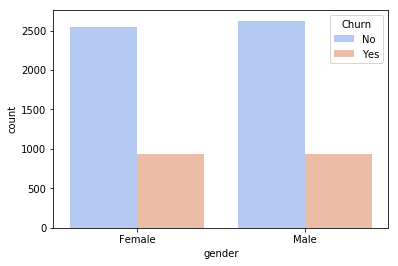

SeniorCitizen : [0 1] 



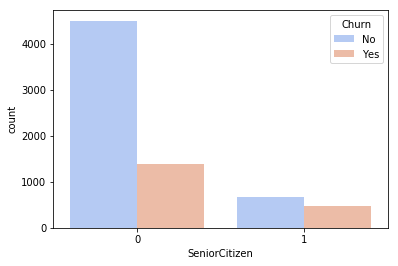

Partner : ['Yes' 'No'] 



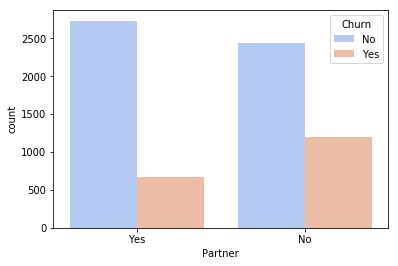

Dependents : ['No' 'Yes'] 



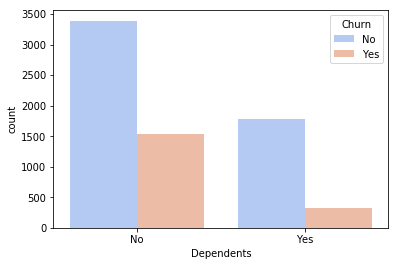

PhoneService : ['No' 'Yes'] 



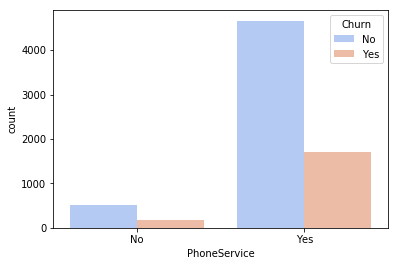

MultipleLines : ['No phone service' 'No' 'Yes'] 



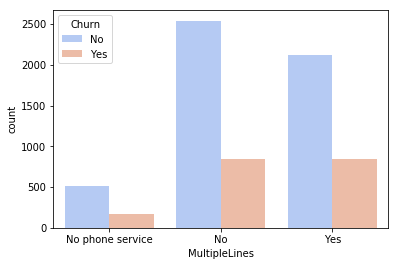

InternetService : ['DSL' 'Fiber optic' 'No'] 



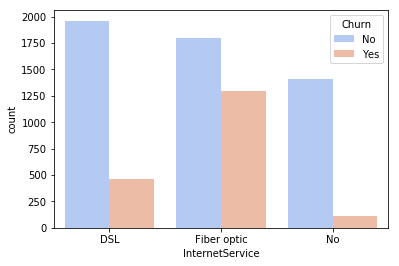

OnlineSecurity : ['No' 'Yes' 'No internet service'] 



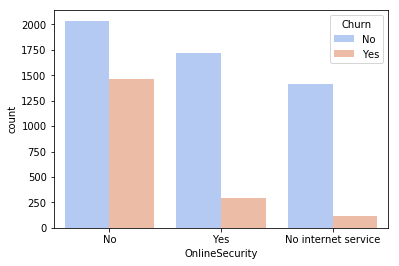

OnlineBackup : ['Yes' 'No' 'No internet service'] 



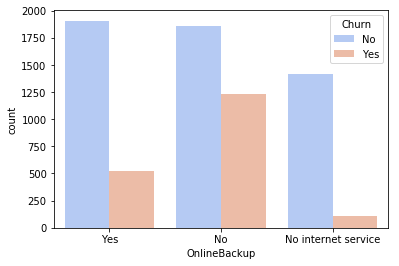

DeviceProtection : ['No' 'Yes' 'No internet service'] 



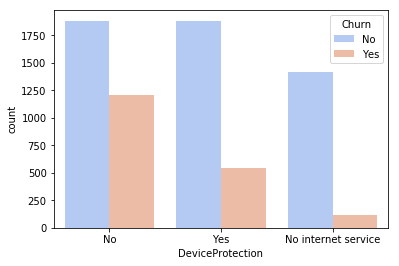

TechSupport : ['No' 'Yes' 'No internet service'] 



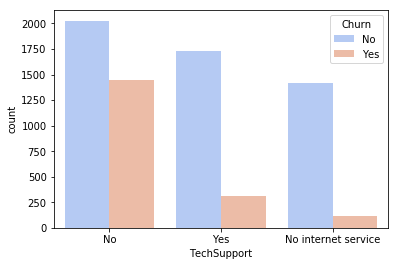

StreamingTV : ['No' 'Yes' 'No internet service'] 



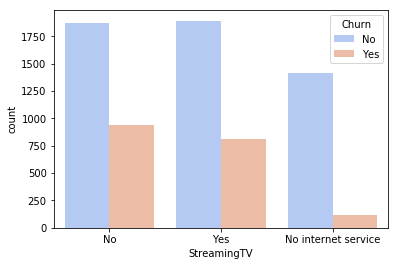

StreamingMovies : ['No' 'Yes' 'No internet service'] 



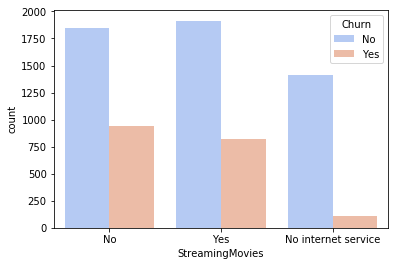

Contract : ['Month-to-month' 'One year' 'Two year'] 



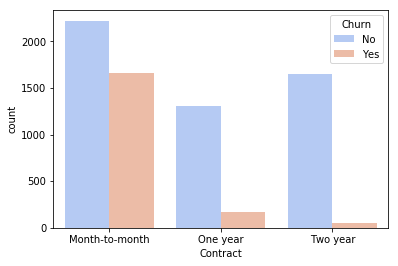

PaperlessBilling : ['Yes' 'No'] 



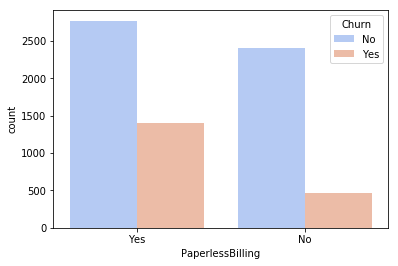

PaymentMethod : ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)'] 



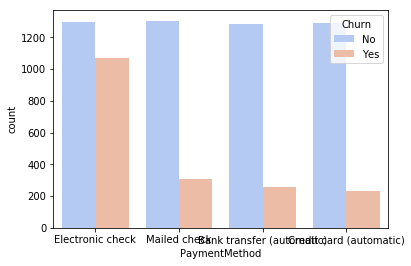

Churn : ['No' 'Yes'] 



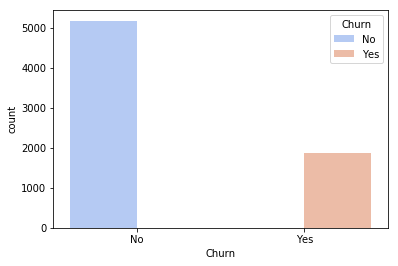

In [5]:
# 'No ineternet service' & 'No phone service' will probably need to be removed since they are indicated in their own columns
# As a rough check, let's see how churn and non-churn customers are distributed by each categorical columns

for col in df.columns:
    if col not in ['customerID','MonthlyCharges', 'TotalCharges', 'tenure']:
        print(col,':', df[col].unique(),'\n')
        sns.countplot(col, data=df, palette='coolwarm', hue='Churn')
        plt.show()

It looks like the gender is not playing much role but we will keep it there for now

The data seems imbalanced in terms of churn/no-churn customers which we will have to fix by undersampling

Below code will process the data-cleanse that we mentioned above.

In [6]:
# creating a copy to clean the data and store
df_edited = df.copy()

# cleaning up the categorical into booleans
df_edited = df.replace({'No internet service':0, 'No phone service':0, 'No':0, 'Yes':1})
df_edited.replace({'InternetService': {0: 'No'}}, inplace=True)

# Replacing Empty Total Charges with Monthly Charges under the assumption that these are new accounts & converting it to float
df_edited['TotalCharges'].loc[df_edited['TotalCharges']==' '] = df_edited[df_edited['TotalCharges']==' ']['MonthlyCharges']
df_edited['TotalCharges'] = df_edited.TotalCharges.astype('float64')

# dropping the customer id since it is very unlikeyly that it's useful
df_edited.drop('customerID', axis=1, inplace=True)

# getting dummy values for the categorical values
gender = pd.get_dummies(df_edited.gender, drop_first=True, prefix='gender')
PaymentMethod = pd.get_dummies(df_edited.PaymentMethod, drop_first=False, prefix='PaymentMethod')
Contract = pd.get_dummies(df_edited.Contract, drop_first=False, prefix='Contract')
InternetService = pd.get_dummies(df_edited.InternetService, drop_first=False, prefix='InternetService')

# drop the original columns and add dummy columns
df_edited.drop(['gender', 'PaymentMethod','Contract','InternetService'], axis=1, inplace=True)
df_edited = pd.concat([df_edited, gender, PaymentMethod, Contract, InternetService], axis=1)

# let's check if the columns are clean enough to be used in modeling
for col in df_edited.columns:
    if col not in ['customerID','MonthlyCharges', 'TotalCharges', 'tenure']:
        print(col,':', df_edited[col].unique(),'\n')

SeniorCitizen : [0 1] 

Partner : [1 0] 

Dependents : [0 1] 

PhoneService : [0 1] 

MultipleLines : [0 1] 

OnlineSecurity : [0 1] 

OnlineBackup : [1 0] 

DeviceProtection : [0 1] 

TechSupport : [0 1] 

StreamingTV : [0 1] 

StreamingMovies : [0 1] 

PaperlessBilling : [1 0] 

Churn : [0 1] 

gender_Male : [0 1] 

PaymentMethod_Bank transfer (automatic) : [0 1] 

PaymentMethod_Credit card (automatic) : [0 1] 

PaymentMethod_Electronic check : [1 0] 

PaymentMethod_Mailed check : [0 1] 

Contract_Month-to-month : [1 0] 

Contract_One year : [0 1] 

Contract_Two year : [0 1] 

InternetService_DSL : [1 0] 

InternetService_Fiber optic : [0 1] 

InternetService_No : [0 1] 



Now, let's look at the numerical columns to see if there's anything interesting

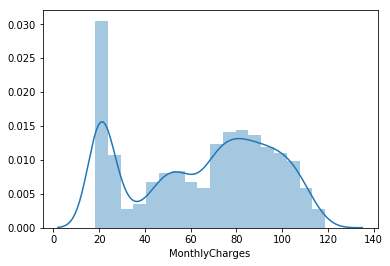

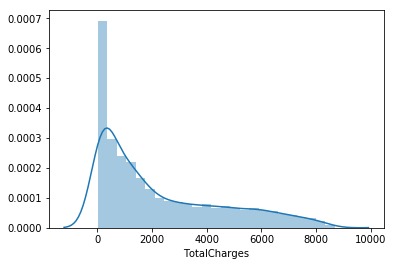

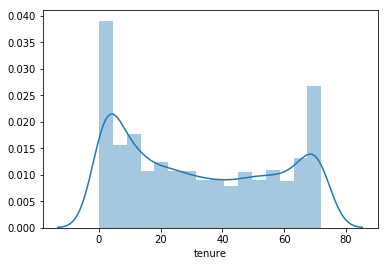

In [7]:
for col in ['MonthlyCharges', 'TotalCharges', 'tenure']:
    sns.distplot(df_edited[col])
    plt.show()

Let's see if the expectation of 'high tenure = high TotalCharges' is correct

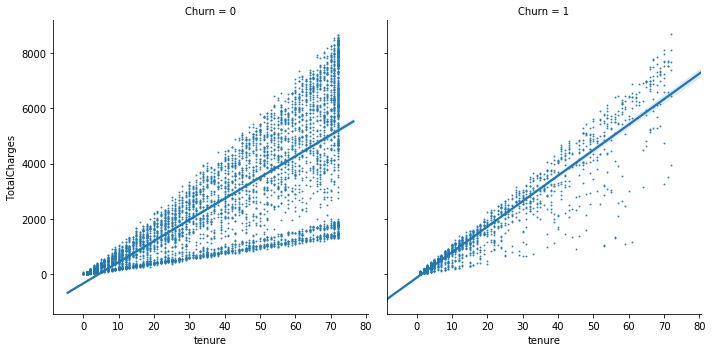

In [8]:
g = sns.lmplot(x='tenure', y='TotalCharges', data=df_edited, col = 'Churn',
          scatter_kws = dict(s=1))

Slopes are as expected but there's a difference between the churn groups.

It looks like the churning group has higher slope, let's check the slope.

In [9]:
model_linear = LinearRegression()
no_churn = df_edited[df_edited['Churn']==0]
churn = df_edited[df_edited['Churn']==1]
model_linear.fit(X=no_churn['tenure'].values.reshape(-1,1),y=no_churn['TotalCharges'].values.reshape(-1,1))
print('no churn:',model_linear.coef_[0][0])
model_linear.fit(X=churn['tenure'].values.reshape(-1,1),y=churn['TotalCharges'].values.reshape(-1,1))
print('churn:',model_linear.coef_[0][0])

no churn: 76.68859782522073
churn: 92.35916091867004


This highly likely means that churning customers have higher MonthlyCharges

Let's check the distribution of MonthlyCharges.

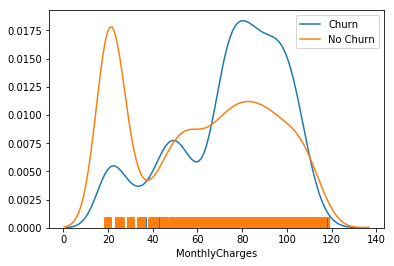

In [10]:
Churn = df_edited[df_edited.Churn==1]
No_Churn = df_edited[df_edited.Churn==0]

sns.distplot(Churn[['MonthlyCharges']], hist=False, rug=True, label='Churn', axlabel='MonthlyCharges')
sns.distplot(No_Churn[['MonthlyCharges']], hist=False, rug=True, label='No Churn')
plt.show()

We can deduce from this that majority of churning customers have higher MonthlyCharges.

Now, before preparing the train and test data, we need to fix the imbalance.
The plan is to match the numbers of the Churn and No-Churn groups.

In [11]:
print(df_edited.Churn.value_counts())

0    5174
1    1869
Name: Churn, dtype: int64


1    1869
0    1869
Name: Churn, dtype: int64


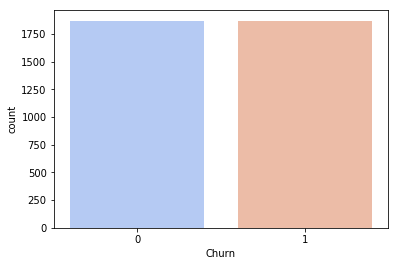

In [12]:
# we will use randomized 1869 customers of no_churn group.
df_edited = df_edited.sample(frac=1)
df_edited_balanced = pd.concat([df_edited[df_edited['Churn']==1],df_edited[df_edited['Churn']==0][:1869]],axis=0)
sns.countplot(df_edited_balanced['Churn'], palette='coolwarm')
print(df_edited_balanced.Churn.value_counts())

For the models, we will try LogisticRegression, RandomForestClassifier, and XGBoostClassifier.
The default settings will be used for these and once we select a model, we can dive into improvements.

In [13]:
# Prepare the train and test data sets
X=df_edited_balanced.drop('Churn', axis=1)
y=df_edited_balanced.Churn
test_size = 0.3
random_state = 70
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

models = [LogisticRegression(),DecisionTreeClassifier(), RandomForestClassifier(), XGBClassifier()]
for model in models:
    print ('\n','-'*100,'\n',model)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(confusion_matrix(y_test,y_pred))
    print(classification_report(y_test,y_pred))


 ---------------------------------------------------------------------------------------------------- 
 LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)
[[397 169]
 [115 441]]
              precision    recall  f1-score   support

           0       0.78      0.70      0.74       566
           1       0.72      0.79      0.76       556

    accuracy                           0.75      1122
   macro avg       0.75      0.75      0.75      1122
weighted avg       0.75      0.75      0.75      1122


 ---------------------------------------------------------------------------------------------------- 
 DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=Non

XGBoost and LogisticRegression are the best contenders.
Just out of curiosity, let's take a look at the results without the undersampling.

In [14]:
# Prepare the train and test data sets
X=df_edited.drop('Churn', axis=1)
y=df_edited.Churn
test_size = 0.3
random_state = 70
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

models = [LogisticRegression(),DecisionTreeClassifier(), RandomForestClassifier(), XGBClassifier()]
for model in models:
    print ('\n','-'*100,'\n',model)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(confusion_matrix(y_test,y_pred))
    print(classification_report(y_test,y_pred))


 ---------------------------------------------------------------------------------------------------- 
 LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)
[[1415  140]
 [ 259  299]]
              precision    recall  f1-score   support

           0       0.85      0.91      0.88      1555
           1       0.68      0.54      0.60       558

    accuracy                           0.81      2113
   macro avg       0.76      0.72      0.74      2113
weighted avg       0.80      0.81      0.80      2113


 ---------------------------------------------------------------------------------------------------- 
 DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features

We can confirm that the overall accuracy went up but the sensitivity for actual churning customers have dropped significantly. I believe the purpose of these models are to predict which customers are churning and above result shows that fixing the imbalance with undersampling is a necessity for training these models.